# KNN classifier from scratch
This notebook features the building of a Nearest Neighbors classifier featuring 4 different variants using only basic libraries

- Classic Knn 
- Classic Parzen Window 
- Parzen Window with Kernels
- KNN with Kernel (This method can be manually modified to work as a Parzen Window with variable Radius and Kernel)

The following optimization parameters are currently available: 

- Minkowski distance with variable p 
- 3 Kernels (epanechnikov, gaussian and logistic) 
- Neighbours (k) for variant 1 and 4
- Window radius (r) for variant 2 and 3
-----------------------------------------------------------

Essential for usage: 
- Format your data with data_prep .transform() and .normalize() 
- Create a instance of the KNN class with a specific dataset.
- Run .optimize with a specific method or all methods (parameters are maximum k, maximum radius,maximum p and stepsize for the radius.). 

Results will be displayed.


Additionally: 
This notebook features a data preparation class that will format, numberize and normalize your dataset.
(Class should be the last columm in raw data)

In [13]:
# libaries that are required
import numpy
import operator
import math
import random
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
# data preperation class 
class data_prep:
    def __init__(self,location):
        self.data = open(location, "r+")
        self.data = self.data.read()
        self.data = self.data.splitlines()
        
    def lNumberizer(self):
            count = 0
            labels = {}
            for x in self.data:
                if x[1][0] not in labels:
                    labels[x[1][0]] = count
                    count+=1
            for x in self.data:
                x[1] = labels[x[1][0]]
            return self.data
        
    def numberize(self,dataset,toNumberize):
        data = numpy.transpose(dataset)
        for x in toNumberize: 
            count= 0 
            labels = {}
            for z in data[int(x)]:
                if z not in labels:
                    labels[z] = count
                    count+=1
            for w in range (len(data[int(x)])):
                data[int(x)][w] = labels[data[int(x)][w]]
        data = numpy.transpose(data)
        data = data.tolist()
        return data
                       
    def transform(self,numbers = "y"):
        data = self.data
        del data[0]
        if data[0] == "":
            del data[0]
        self.N = len(data)
        for x in range(self.N):
            data[x] = data[x].replace(",", "-split-")
            data[x] = data[x].split("-split-")
        if numbers == "n":
            print("Please specifiy the features that are not floats. (0 1 4)")
            answer = input().split()
            data = self.numberize(data,answer)
        for w in range(self.N):
            for y in range(len(data[w])-1):
                data[w][y] = float(data[w][y]) 
        features = len(data[0])-1
        for x in range(self.N):
            data[x] = [data[x][:features],data[x][features:]]
        self.data = numpy.array(data)
        data = self.lNumberizer()
        self.transformed = data
         
    def normalize(self):
        features = []
        holder = self.transformed
        for x in holder:
            features.append(x[0])
        features = numpy.array(features)
        features = numpy.transpose(features)
        for y in range(len(features)):
            maxi = max(features[y])
            mini = min(features[y])
            for z in range (len(features[y])):
                features[y][z] =  (features[y][z]- mini)/ (maxi - mini)
        
        features = numpy.transpose(features)
        for w in range(len(features)):
            holder[w][0] = features[w]
        self.normalized = holder

In [15]:
# Main Knn class
class KNN:
    def __init__(self,dataset):
        self.data = dataset
        self.kernels = {0: self.epanechnikov, 1: self.gaussian, 2: self.logistic}  # add new kernels here !
        self.maxOfMethod = [0]*4  # add new methods here !

    def minkowski_distance(self, basis, example,p):        # Distance function to calculate 
        eucl = []                                          # the distance for all datapoints.
        for v in range(0,len(basis)):
            distance = 0 
            for y in range(len(example[0])):
                distance = distance + ((basis[v][0][y]-example[0][y])**p)
            distance**(1/p)
            eucl.append(distance)
        return eucl
        
    def create_cm(self,prediction,label):                  # Method that creates a confusion matrix from cross-validation
        Nlabels = max(label)+1                             # predictions, which is used for F1 score.
        cm = numpy.zeros((Nlabels, Nlabels))
        for x in range (len(prediction)):
            cm[label[x]][prediction[x]]+= 1
        return cm
        
    def calc_F1(self,conf):                                # F1 score calculation from scratch 
        def class_weights(cm):
            weights = []
            for x in range(len(conf[0])):
                weight = sum(conf[x])
                weights.append(weight)
            return weights
        def precision(cm):
            prec = []
            for x in range(len(conf[0])):
                FPTP = 0 
                for y in range(len(conf)):
                    FPTP = FPTP + conf[y][x]
                if FPTP == 0:
                    prec.append(0.0)
                else:
                    precision = conf[x][x] / FPTP
                    prec.append(precision)
            
            return prec
        def recall(conf):
            rec = []
            for x in range(len(conf[0])):
                TPFN = sum(conf[x])
                if TPFN == 0: 
                    rec.append(0.0)
                else:
                    recall = conf[x][x] / TPFN
                    rec.append(recall)
            return rec
        def f1_measure(precision,recall):
            scores = []
            for x in range(len(conf[0])):
                if precision[x] == 0 and recall[x] == 0 :
                    score = 0.0
                else: 
                    score = 2*(recall[x] * precision[x]) / (recall[x] + precision[x])
                scores.append(score)
            return scores
        def weighted_f1_micro(f1,weights):                          # micro F1 is currently used. Could be replaced with macro.
            wF1 = map(lambda x, y: x * y, f1,weights) 
            if sum(weights)== 0:
                return 0.0
            else:
                micro = (sum(wF1))/(sum(weights))
            return micro
        weights = class_weights(conf)
        precision = precision(conf)
        recall = recall(conf)
        F1 = f1_measure(precision,recall)
        microF1 = weighted_f1_micro(F1,weights)
        return microF1
    
    def epanechnikov(self,distance):                     # Kernel functions that return the transformed distance 
        kernel = []
        for x in distance: 
            kernel.append(3/4*(1-x**2))
        return kernel
    
    def gaussian(self,distance): 
        kernel = []
        for x in distance: 
            kernel.append(1/(math.sqrt(2*math.pi))*(math.e**(-1/2*(x**2))))
        return kernel 
    
    def logistic (self,distance):
        kernel = []
        for x in distance: 
            kernel.append(1/(math.e**x + 2 + math.e**(-x)))
        return kernel  
    
    def predict_vanilla(self,basis, input,k,p):                                   # Predict methods which predict 
            differences = numpy.array(self.minkowski_distance(basis,input,p))     # one datapoint based on the rest 
            idx = numpy.argpartition(differences, k)                              # of the data
            majorityCount = {}
            for x in range(k):
                if basis[idx[x]][1] in majorityCount:
                    majorityCount[basis[idx[x]][1]] += 1
                else:
                    majorityCount[basis[idx[x]][1]] = 1
            result = max(majorityCount.items(), key=operator.itemgetter(1))[0]
            return result
    
    def predict_parzen_vanilla(self,basis, input,r, p):
        differences = numpy.array(self.minkowski_distance(basis,input,p))
        inRange = []
        majorityCount = {}
        for x in range(len(differences)):
            if differences[x] <= r:
                inRange.append(x)
        if bool(inRange) == True : 
            for x in inRange:
                if basis[x][1] in majorityCount:
                    majorityCount[basis[x][1]] += 1
                else:
                    majorityCount[basis[x][1]] = 1
            result = max(majorityCount.items(), key=operator.itemgetter(1))[0]
            return result
        else: 
            result = random.choice(basis)
            return result[1]
                                                                          
    def predict_kernel_knn(self,basis, input,k,p,kernel, window=False):  ## Can be modified to calculate a variable parzen window.
        differences = numpy.array(self.minkowski_distance(basis,input,p))   ## Just set windo = True 
        if window == False:                                                 ## <-------
            idx = numpy.argpartition(differences, k)
        else: 
            idx = numpy.argpartition(differences, k+1)
            differences = numpy.divide(differences,differences[idx[k+1]])
        kernelValues = kernel(differences)
        maxCount = {}
        for x in range(k):
            if basis[idx[x]][1] in maxCount:
                maxCount[basis[idx[x]][1]] += kernelValues[idx[x]]
            else:
                maxCount[basis[idx[x]][1]] = kernelValues[idx[x]]
        result = max(maxCount.items(), key=operator.itemgetter(1))[0]
        return result
        
    def predict_kernel_parzen(self,basis,input,r,p,kernel): 
        differences = numpy.array(self.minkowski_distance(basis,input,p))
        differences = numpy.divide(differences,r)
        kernelValues = kernel(differences)
        maxCount = {}
        for x in range (len(kernelValues)): 
            if basis[x][1] in maxCount:
                maxCount[basis[x][1]] += kernelValues[x]
            else: 
                maxCount[basis[x][1]] =  kernelValues[x]
        result = max(maxCount.items(), key=operator.itemgetter(1))[0]
        return result
                
    
    def loo_cv(self,p,Nversion,k=None,r=None, kernel=None ):  ## Cross validation method that calculates F1 score
        results = []                                          ## for given model variables
        if Nversion == "vanillaKnn":
            for x in range(len(self.data)):
                result = self.predict_vanilla(numpy.concatenate((self.data[:x], self.data[x+1:]), axis=0), self.data[x],k,p)
                results.append(result)
        elif Nversion == "vanillaParzen":
            for x in range(len(self.data)):
                result = self.predict_parzen_vanilla(numpy.concatenate((self.data[:x], self.data[x+1:]), \
                axis=0), self.data[x],r,p)
                results.append(result)
        elif Nversion == "kernelParzen":  
            for x in range(len(self.data)):
                result = self.predict_kernel_parzen(numpy.concatenate((self.data[:x], self.data[x+1:]),\
                axis=0), self.data[x],r,p,kernel)
                results.append(result)
        elif Nversion == "kernelKnn":
            for x in range(len(self.data)):
                result = self.predict_kernel_knn(numpy.concatenate((self.data[:x], self.data[x+1:]), \
                axis=0), self.data[x],k,p,kernel)
                results.append(result)
        labels = []
        for y in range (len(self.data)):
            labels.append(self.data[y][1])   
        confusion = self.create_cm(results,labels)
        F1 = self.calc_F1(confusion)
        return F1
    
    def optimize_vanilla_knn(self,maxk, maxp):             # Optimization methods for all 4 variants.
        scoresVanilla = numpy.zeros((maxk, maxp))          # Methods runs cross validation for every 
        for x in range (1,maxk+1):                         # possible parameter combination and proints results.
            for y in range (1,maxp+1): 
                score = self.loo_cv(y,"vanillaKnn",k=x)
                scoresVanilla[x-1][y-1] = score
        print("Vanilla KNN:")
        self.scoresVanillaKnn = scoresVanilla
        self.maxOfMethod[0] = (numpy.amax(scoresVanilla))
        self.display_vanilla(scoresVanilla,maxk,maxp)
        
    def optimize_parzen_vanilla(self, maxR,maxp,rSteps=0.1):
        radiusSteps = int(maxR/rSteps)
        scoresParzenVanilla = numpy.zeros((radiusSteps, maxp))
        for z in range(1,radiusSteps+1):
            for w in range (1,maxp+1):
                score = self.loo_cv(w,"vanillaParzen",r=(z*rSteps))
                scoresParzenVanilla[z-1][w-1] = score
        self.scoresParzenVanilla = scoresParzenVanilla
        self.maxOfMethod[1] = (numpy.amax(scoresParzenVanilla))
        print("Parzen Vanilla:")
        self.display_vanilla(scoresParzenVanilla,radiusSteps,maxp)
        
    def optimize_kernel_parzen(self, maxR,maxp,rSteps=0.1):
        radiusSteps = int(maxR/rSteps)
        kernelFrame = []
        for y in range(len(self.kernels)): 
            scoresKernelParzen = numpy.zeros((radiusSteps, maxp))
            for z in range(1,radiusSteps+1):
                for w in range (1,maxp+1):
                    score = self.loo_cv(w,"kernelParzen",r=(z*rSteps),kernel = self.kernels[y])
                    scoresKernelParzen[z-1][w-1] = score
            kernelFrame.append(scoresKernelParzen)
        self.scoresKernelParzen = scoresKernelParzen
        self.maxOfMethod[2] = (numpy.amax(kernelFrame))
        print("Parzen with Kernel:")
        self.display_kernel(kernelFrame,radiusSteps,maxp)  

    def optimize_kernel_knn(self, maxK,maxp):
        kernelFrame = []
        for z in range(len(self.kernels)): 
            scoresKernel = numpy.zeros((maxK, maxp))
            for x in range (1,maxK+1):
                for y in range (1,maxp+1): 
                    score = self.loo_cv(y,"kernelKnn",k=x, kernel=self.kernels[z])
                    scoresKernel[x-1][y-1] = score
            kernelFrame.append(scoresKernel)
        self.scoresKernelKnn = scoresKernel
        self.maxOfMethod[3] = (numpy.amax(kernelFrame))
        print("KNN with Kernel:")
        self.display_kernel(kernelFrame,maxK,maxp)
                       
    def optimize_all(self,maxK,maxR, maxp,rSteps=0.1):         # Runs all optimizations and sums up the results
        self.optimize_vanilla_knn(maxK,maxp)
        self.optimize_parzen_vanilla(maxR,maxp,rSteps)
        self.optimize_kernel_parzen(maxR,maxp,rSteps)
        self.optimize_kernel_knn(maxK,maxp)
        print("The methods achieved the following maximum F1 scores")
        out = numpy.transpose([["Vanilla Knn", "Vanilla Parzen", "Parzen with Kernel", "Knn with Kernel"],self.maxOfMethod])
        out = pd.DataFrame(out,columns=["Method","Max F1"])
        print(out)
        
    def display_vanilla(self,scores,max1,max2):                     # Display methods for tables and plots
        max = numpy.where(scores == numpy.amax(scores))
        transform = list(zip(max[0], max[1]))
        bestP =transform[0][1]
        print("The best F-scores where found using minkowski_distance with p = " + str(bestP+1))
        self.format_plot(bestP,max1,scores)
        print ("The below Table shows all F1 values (columms = p+1 , rows = k+1)")
        print (pd.DataFrame(scores))
        print("")

    def display_kernel(self,scores,max1,max2):
        bestP = numpy.where(scores == numpy.amax(scores))  
        bestP = list(zip(bestP[0], bestP[1],bestP[2]))
        print("The best F-scores where found using minkowski_distance with p =" + str(bestP[0][2]+1)+ "and " +  \
              " and Kernel Nr." + str(bestP[0][0]))
        self.format_plot(bestP[0][2],max1,scores[bestP[0][0]])
        print ("The below Table shows all F1 values (columms = p+1 , rows = k+1 or r/Stepsize) and the best Kernel")
        for x in range(len(scores)):
            print(pd.DataFrame(scores[x]))
            print("")
    
    def format_plot(self,bestP,max1,f1,):
        forPlot = numpy.transpose(f1)
        a = list(range(1, max1+1))
        plt.plot(a, forPlot[bestP])
        plt.xlabel('k   /   r*stepsize')
        plt.ylabel('F-score')
        plt.title("F1 score based on p=" + str(bestP+1) )
        plt.show()


In [19]:
#Data prep:

ecoli = data_prep("data/ecoli.csv")
ecoli.transform()
ecoli.normalize()


iris = data_prep("data/iris.csv")
iris.transform()
iris.normalize()


sonar = data_prep("data/sonar.csv")
sonar.transform()
sonar.normalize()

vehicle = data_prep("data/vehicle.csv")
vehicle.transform()
vehicle.normalize()

vowel = data_prep("data/vowel.csv")   # ("n") signalized that data has to be numberized.
vowel.transform("n")                 #  Specify the columms afterwards. columms that are not floats: 0 1
vowel.normalize()


Please specifiy the features that are not floats. (0 1 4)
0 1


In [10]:
zoo = data_prep("kNN/zoo.csv")       #Wrong label selected (Since label is not last columm)
zoo.transform("n")                   # columms to transform: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 (strg+c)
zoo.normalize()

Please specifiy the features that are not floats. (0 1 4)
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16


Vanilla KNN:
The best F-scores where found using minkowski_distance with p = 2


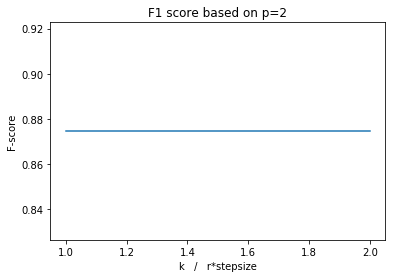

The below Table shows all F1 values (columms = p+1 , rows = k+1)
          0        1
0  0.296627  0.87465
1  0.296627  0.87465

Parzen Vanilla:
The best F-scores where found using minkowski_distance with p = 2


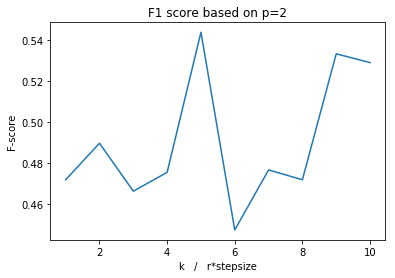

The below Table shows all F1 values (columms = p+1 , rows = k+1)
         0         1
0  0.44288  0.471741
1  0.43963  0.489530
2  0.44288  0.466160
3  0.44288  0.475340
4  0.43963  0.543619
5  0.44288  0.447282
6  0.44288  0.476508
7  0.43963  0.471741
8  0.44288  0.533100
9  0.44288  0.528846



C:\Users\igors\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:93: RuntimeWarning: overflow encountered in double_scalars


Parzen with Kernel:
The best F-scores where found using minkowski_distance with p =2and  and Kernel Nr.2


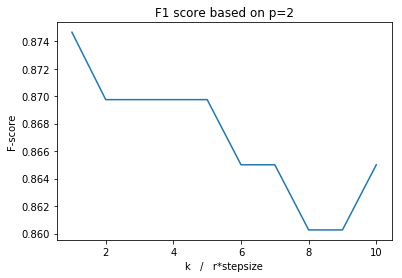

The below Table shows all F1 values (columms = p+1 , rows = k+1 or r/Stepsize) and the best Kernel
          0        1
0  0.638998  0.50099
1  0.638998  0.50099
2  0.638998  0.50099
3  0.638998  0.50099
4  0.638998  0.50099
5  0.638998  0.50099
6  0.638998  0.50099
7  0.638998  0.50099
8  0.638998  0.50099
9  0.638998  0.50099

          0         1
0  0.509615  0.526824
1  0.490385  0.686251
2  0.461138  0.756655
3  0.475340  0.779941
4  0.478633  0.801940
5  0.479316  0.836720
6  0.479316  0.860619
7  0.454866  0.860528
8  0.478633  0.860411
9  0.498600  0.865159

          0         1
0  0.494593  0.874650
1  0.479899  0.869747
2  0.478633  0.869747
3  0.474163  0.869747
4  0.454866  0.869747
5  0.487519  0.865008
6  0.520969  0.865008
7  0.524498  0.860268
8  0.537579  0.860268
9  0.541914  0.865008

KNN with Kernel:
The best F-scores where found using minkowski_distance with p =2and  and Kernel Nr.0


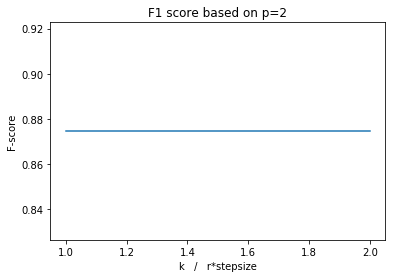

The below Table shows all F1 values (columms = p+1 , rows = k+1 or r/Stepsize) and the best Kernel
          0        1
0  0.296627  0.87465
1  0.296627  0.87465

          0        1
0  0.296627  0.87465
1  0.296627  0.87465

          0        1
0  0.296627  0.87465
1  0.296627  0.87465

The methods achieved the following maximum F1 scores
               Method              Max F1
0         Vanilla Knn  0.8746500559910415
1      Vanilla Parzen  0.5436185832802897
2  Parzen with Kernel  0.8746500559910415
3     Knn with Kernel  0.8746500559910415


In [17]:
# Optimize all 4 methods and display all results

Model = KNN(sonar.normalized)    # put dataset here
Model.optimize_all(2,0.1, 2, rSteps = 0.01)  # select maximization parameters

# enjoy
